# Emu-Chicken Limb RNA-Seq Analysis
This document describes the steps used to analyse the emu and chicken RNA-Seq data published in “Co-option of the cardiac regulator Nkx2.5 during evolution and development of the emu wing” (SRA accession SRP106587). Two RNA-Seq experiments were analysed (we describe both together here as some of the preprocessing steps were in common):
   * Emu and Chicken Limb - Designed to find genes which explain the stunted development of emu wings (unlike emu legs). Chicken limbs were also sequenced as a control (as chickens have fully developed wings). The samples consisted of:
      * Emu forelimb x2 biological replicates
      * Emu hindlimb x2 biological replicates
      * Chicken forelimb x2 biological replicates
      * Chicken hindlimb x2 biological replicates
   
   
   * Based on the results of the intial experiment, NKX2-5 was found to be expressed only in the emu forelimb samples. Overexpression of this gene in chicken wings was used to determine which genes/pathways it altered. The design in this case consisted of:
       * Chicken forelimb controls x3 biological replicates
       * Chicken forelimb with NKX2-5 overexpression x3 biological replicates

## Data Quality Checks and Cleaning

All samples were run through fastqc to check the quality. No quality issues were identified.
All reads were then trimmed to remove low quality bases at the start and end of each read using trimmomatic: 

```
Trimmmomatic PE -phred33 $INPUT_LEFT $INPUT_RIGHT $TRIMMED_LEFT_PAIRED $TRIMMED_LEFT_UNPAIRED $TRIMMED_RIGHT_PAIRED $UNPAIRED_RIGHT_UNPAIRED LEADING:20 TRAILING:20 MINLEN:50
```
   
   Where LEFT and RIGHT refers to the two ends of the read pair. Only reads still paired after trimming were used in subsequent steps.</p></li>

## Going from Chicken Reads to Counts
The chicken RNA-Seq reads (for both the emu-chicken comparison as well as the NKX2.5 misexpression analysis) were aligned and then counted using the methods described below.

#### Alignment
Reads were aligned to the galGal4 version of the chicken genome (downloaded from UCSC) using tophat:

```
tophat -p2 -G ANN.gtf -o tophat_PREFIX REF R1 R2
```

Where ANN.gtf is the chicken Ensmebl annotation downloaded from UCSC table browser on 8th Nov. 2013, PREFIX is the sample name and R1 and R2 refer to the trimmed fastq read pairs. REF is the indexed version of galGal4.

#### Counting
Aligned reads were counted using featureCounts:

``` 
featureCounts -b -p -a ANN.saf -t exon -g gene_id -i BAMS -o counts -F SAF 
```

Where BAMS was the aligned reads .bam files and ANN.saf was an annotation file. The ANN.saf file was constructed by downloading the Ensmebl galGal4 annotation from UCSC (select fields - chrom, strand, exonStarts, exonEnds, name2) and using in house scripts to convert to saf format.

## Going from Emu Reads to Counts

Analysis of the emu data required a more complex approach because emu did not have a reference genome available. Here, we instead de novo assemble the reads and use the assembled transcriptome as a reference, later annotating it using the chicken transcriptome.

### Assembly
The reads from all emu samples were pooled and assembled with Trinity.
```
Trinity.pl --JM 150G --CPU 8 --full_cleanup --seqType fq --left LEFT_POOL --right RIGHT_POOL
```
Where LEFT_POOL and RIGHT_POOL are the pooled set of emu reads.

### Alignment 
Reads were aligned against the assembled transcriptome for each sample using bowtie.
```
bowtie -p4 --all -X1000 REF -1 TRIMMED_LEFT_PAIRED -2 TRIMMED_RIGHT_PAIRED -S SAMPLE.sam ; samtools view -S -b SAMPLE.sam > SAMPLE.bam
``` 
Where REF is the bowtie-indexed Trinity assembly.

### Counting and clustering
Corset was used to simultaneously cluster contigs from the same gene together and count the number of reads aligning to each group of contigs. 
```
corset -g1,1,2,2 *.bam
```

### Annotation
Next we annotated each emu cluster with one or more chicken ensembl gene IDs. Emu contigs were aligned against a fasta file of reference chicken Ensembl transcripts (downloaded from UCSC through the table browser) using BLAST
```
makeblastdb -in galGal4_ensGene.fasta -out galGal4_ensGene -dbtype nucl blastn -query ../../assembly/Trinity.fasta -db galGal4_ensGene -outfmt 6
```
The blast results were filtered for matches with an e-value of < 0.00001 and the chicken transcript with the best reminaing match was found for each emu contig. For each match we used a look-up table to find the associated emu cluster ID and chicken gene ID. Occassionally a contigs within a cluster gave a different best match chicken gene than other contigs in the same cluster. In these cases where the cluster could not be uniquely assigned to a chicken gene, we remove the gene from the analysis.


## Differential Expression Testing Emu-Chicken Analysis

The emu and chicken limb count data was then analysed together in R using limma.

In [1]:
#read in the chicken counts
chicken_count_data<-read.delim("chicken_counts.txt",row.names=1)
chicken_count_data$length<-NULL

#read in the emu counts
emu_count_data<-read.delim("emu_counts.txt",row.names=1)

#get the emu cluster - chicken gene ID associations
mapping=read.delim("cluster-chicken_genes.txt",stringsAsFactors=F)
emuGs<-mapping[,2]
names(emuGs)<-mapping[,1]
genes=split(names(emuGs),emuGs)

In [2]:
# Sometime a chicken gene might have multiple emu clusters associated with it,
# for example because the assembly was only able to reconstruct two halves of a gene.
# We will aggregate the counts of these clusters.
emuC=do.call("rbind",lapply(genes,function(x){ colSums(emu_count_data[x,]) }))

# combine the emu and chicken counts into a single matrix of counts
allC=cbind(emuC,chicken_count_data[rownames(emuC),])
head(allC)

,EF1,EF2,EH1,EH2,CF1,CF2,CH1,CH2
ENSGALG00000000003,123,137,125,133,641,692,519,596
ENSGALG00000000004,1125,1157,1300,810,432,438,407,405
ENSGALG00000000011,1007,963,921,976,1125,1128,1043,1004
ENSGALG00000000013,345,407,365,342,355,329,305,287
ENSGALG00000000019,358,335,374,420,557,552,520,540
ENSGALG00000000033,2234,2359,2206,2289,819,825,892,865


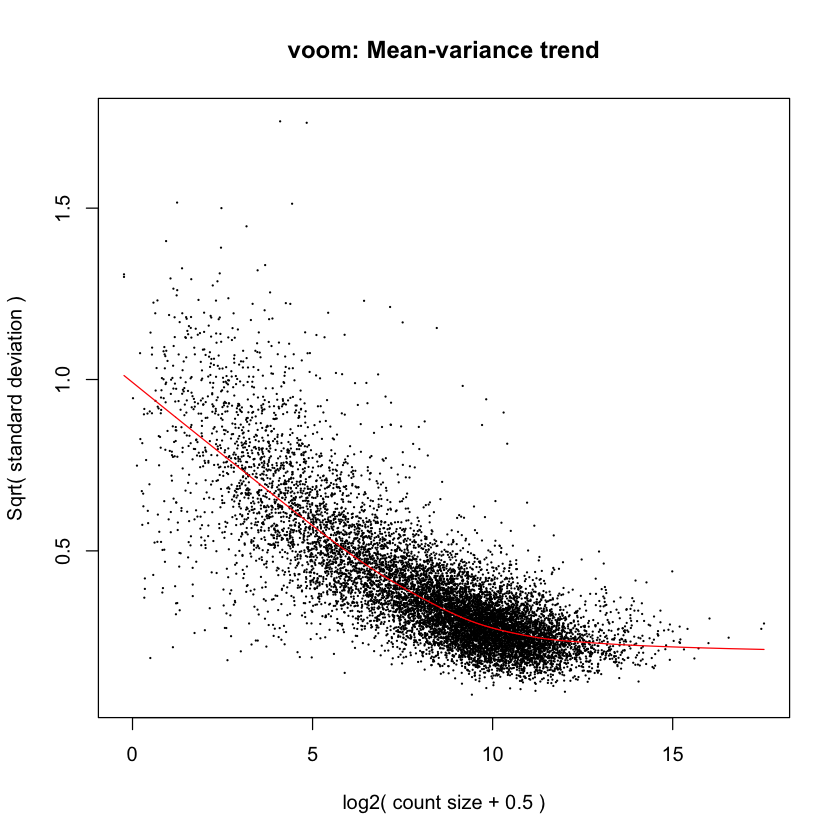

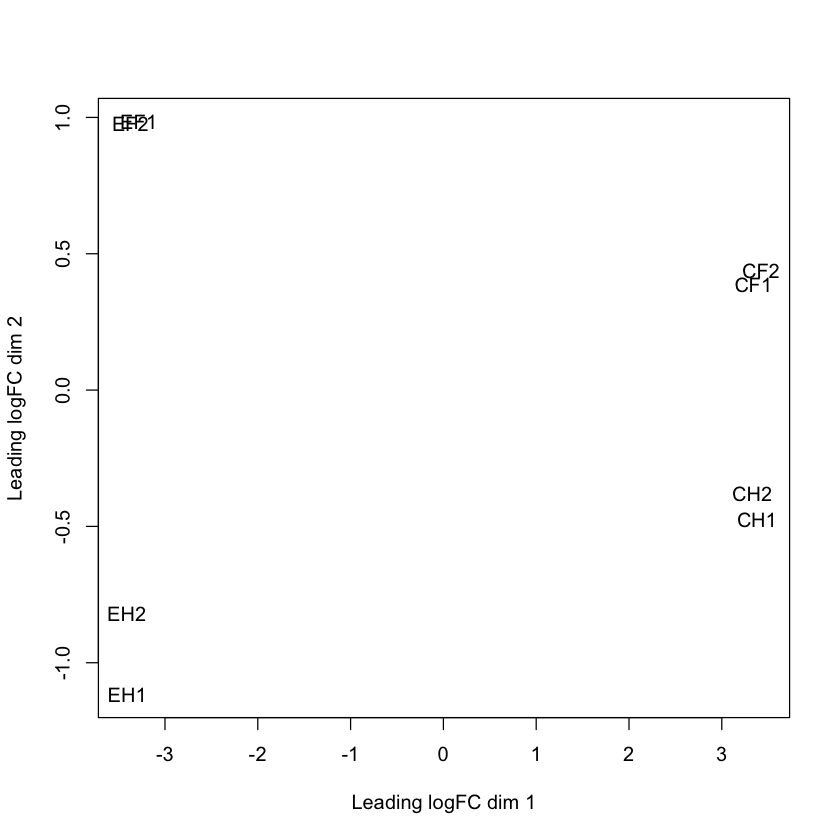

In [3]:
#now do a DE analysis...
library(limma)

group<-factor(c("EF","EF","EH","EH","CF","CF","CH","CH"))
design=model.matrix(~0+group)
colnames(design)<-c("CF","CH","EF","EH")
cont.matrix <- makeContrasts(
            Emu = EF-EH,
            Chicken = CF-CH,
            Diff = (EF - EH) - (CF - CH),
            Comb = (EF - EH) + (CF - CH),
            levels = design )

library("edgeR")
dge<-DGEList(counts=allC)
dge<-calcNormFactors(dge)

y<-voom(dge,design,plot=TRUE)
plotMDS(y)

The MDS plot shows the samples separating by species in dimension 1 and limb type in dimension 2. Biologically replicates are clustering together (E/C=emu/chicken, H/F=hindlimb/forelimb, 1/2=replicate number). The emu fore and hind limb are more separated than the chicken fore-hind limb pair, and we might expect.

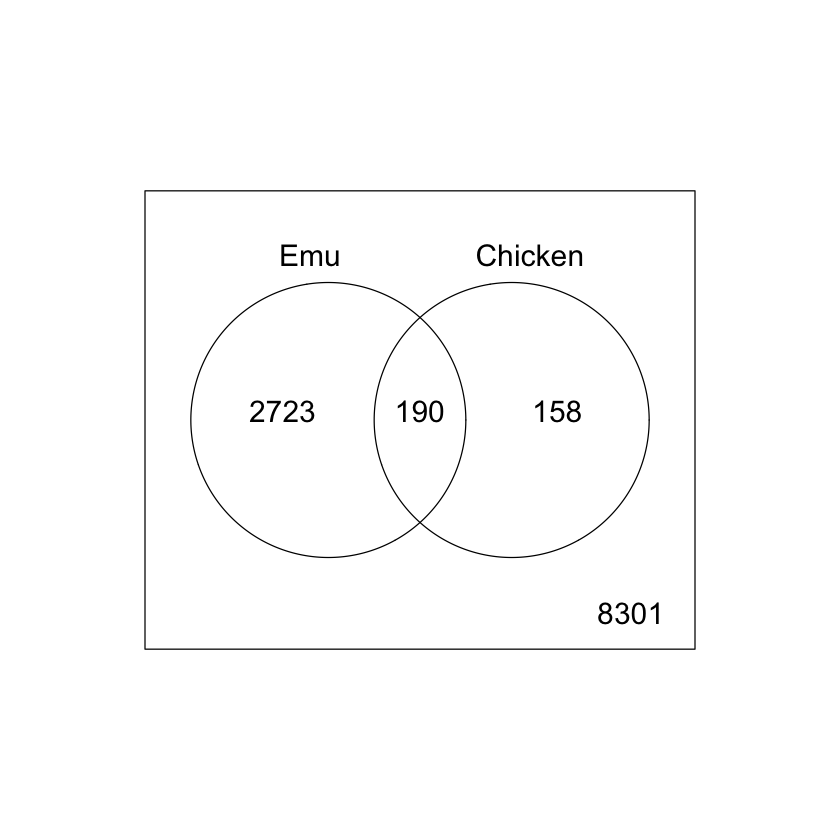

In [4]:
#continue with the analysis
fit <- lmFit(y,design)
fit2 <- eBayes(contrasts.fit(fit, cont.matrix))
results <- decideTests(fit2)

#make a venn diagram of the genes which are differentially expressed between the 
#forelimb and hindlimb for each species
vennDiagram(results[,1:2])
#lots more differences in the emu

In [5]:
# now lets get the results into a nice format and supplement with gene information
all_res_E=topTable(fit2,coef=1,n=dim(allC)[1],sort.by="none")
all_res_C=topTable(fit2,coef=2,n=dim(allC)[1],sort.by="none")
all_res_D=topTable(fit2,coef=3,n=dim(allC)[1],sort.by="none")
all_res_Comb=topTable(fit2,coef=4,n=dim(allC)[1],sort.by="none")

options(digits=3)
gene_info=read.csv("galGal4_ens.info")
rownames(gene_info)<-gene_info$X
info=gene_info[rownames(all_res_E),]

all_res=data.frame( info$Symbol, info$Position, all_res_E$AveExpr ,
            all_res_E$logFC, all_res_C$logFC,
            all_res_Comb$adj.P.Val, all_res_D$adj.P.Val,
            all_res_E$adj.P.Val<0.05, all_res_C$adj.P.Val<0.05
)
colnames(all_res)<-c("Symbol","PositionGalGal4","AverageLog2CPM",
                     "EmuLog2FoldChange","ChickenLog2FoldChange",
                     "AdjustedPValueOfCombined","AdjustedPValueOfDiff",
                     "DEinEmu","DEinChicken")
rownames(all_res)<-rownames(all_res_E)

#get just the genes that are significantly differently different
# i.e. the contrast (EF - EH) - (CF - CH)
int=all_res[all_res$AdjustedPValueOfDiff<0.05,]
head(int)

,Symbol,PositionGalGal4,AverageLog2CPM,EmuLog2FoldChange,ChickenLog2FoldChange,AdjustedPValueOfCombined,AdjustedPValueOfDiff,DEinEmu,DEinChicken
ENSGALG00000000086,TIMM17A,chr26:1094583-1102770,6.77,0.308,-0.03275,0.06998,0.0418,TRUE,FALSE
ENSGALG00000000098,NA,chr22:148115-238186,3.37,-1.155,0.02666,0.01548,0.0181,TRUE,FALSE
ENSGALG00000000137,SNRPE,chr26:1620030-1622178,7.74,0.309,0.00283,0.02425,0.0373,TRUE,FALSE
ENSGALG00000000169,PCNA,chr22:334051-336642,9.07,0.314,0.08633,0.00169,0.0488,TRUE,FALSE
ENSGALG00000000221,PROM2,chr22:446094-452837,1.19,0.820,-1.08053,0.76643,0.0230,FALSE,FALSE
ENSGALG00000000227,CRMP2A,chr22:460056-501407,8.26,0.436,0.05974,0.00344,0.0233,TRUE,FALSE


In [6]:
#rerank by the effect size: |emu fold change | - |chicken fold change|
#because we want changes that only occur in the emu and not chicken.
diff=(abs(int$EmuLog2FoldChange)-abs(int$ChickenLog2FoldChange))
int=int[order(diff,decreasing=T),]
head(int)

,Symbol,PositionGalGal4,AverageLog2CPM,EmuLog2FoldChange,ChickenLog2FoldChange,AdjustedPValueOfCombined,AdjustedPValueOfDiff,DEinEmu,DEinChicken
ENSGALG00000002886,NKX2-5,chr13:8535720-8537935,-2.766,8.59,-0.0602,2.58e-04,5.00e-04,TRUE,FALSE
ENSGALG00000013193,IRX2,chr2:86624613-86631727,0.973,4.84,0.0317,4.36e-03,7.62e-03,TRUE,FALSE
ENSGALG00000009192,SLITRK2,chr4:19131950-19134524,4.059,-4.19,-0.0606,3.14e-06,1.54e-05,TRUE,FALSE
ENSGALG00000015143,TTR,chr2:105824284-105831740,-1.517,4.05,-0.0908,1.71e-02,2.00e-02,TRUE,FALSE
ENSGALG00000027692,KIAA1024L,chrZ:45135086-45136473,-0.361,3.94,0.4491,3.79e-03,2.00e-02,TRUE,FALSE
ENSGALG00000007489,CNNM1,chr6:21690898-21703073,3.510,-3.51,0.0335,5.78e-04,9.51e-04,TRUE,FALSE


In [7]:
#NKX2-5 is the leading gene. How do the raw counts look?
allC[head(rownames(int)),]

,EF1,EF2,EH1,EH2,CF1,CF2,CH1,CH2
ENSGALG00000002886,182,176,0,0,0,0,0,0
ENSGALG00000013193,30,51,4,0,95,133,100,112
ENSGALG00000009192,19,33,472,537,532,541,547,526
ENSGALG00000015143,23,22,1,1,4,4,2,8
ENSGALG00000027692,108,80,4,9,7,5,4,4
ENSGALG00000007489,30,27,460,275,257,324,268,274


## Differential Expression Testing in NKX2-5 Chicken Misexpression Analysis

In this experiment there were 6 samples (all chicken):
   * 3 controls (Sample IDs 3,4,5)
   * 3 with overexpression of NKX2-5 (Sample IDs 9,11,18)

In [8]:
#start by loading the count data
count_data<-read.delim("nkx2-5_counts.txt",skip=1)
counts=count_data[,7:30]

#and clean up the column names
row.names(counts)<-count_data$Geneid
colnames(counts)<-gsub("...map.tophat_PF15R.11.","",colnames(counts))
colnames(counts)<-gsub("_ML150387_151004_H5FCYBGXX_NS500541","",colnames(counts))
colnames(counts)<-gsub(".accepted_hits.bam","",colnames(counts))

In [9]:
# merge lanes as there's no technical replicate issues
# and move sample 9 next to the others with nkx2-5 overexpression so they are together
Mcounts<-data.frame(rowSums(counts[,1:4]),rowSums(counts[,5:8]),rowSums(counts[,21:24]),
                    rowSums(counts[,9:12]),rowSums(counts[,13:16]),rowSums(counts[,17:20]))
colnames(Mcounts)<-c("11","18","9","3","4","5")

#next remove gene with low expression
isexpr = rowSums(Mcounts >= 10) >= 2
Mcounts=Mcounts[isexpr,]

#Show the counts for NKX2-5 as a sanity check
Mcounts["ENSGALG00000002886",]

,11,18,9,3,4,5
ENSGALG00000002886,32035,21958,30321,0,0,2


In [10]:
#Now make the design matrix
group<-factor(c(2,2,2,1,1,1)) #2=overexpression, 1=control

#we will see later that sex is the leading source of variation in the experiment
#fortunatley we can use HINTW to determine sample sex and model it.
Mcounts["ENSGALG00000022674",] #HINTW
sex<-factor(c(1,1,2,1,1,2)) #1-female, 2-male
design=model.matrix(~group+sex)
show(design)

,11,18,9,3,4,5
ENSGALG00000022674,9004,10608,13,9164,13529,34


  (Intercept) group2 sex2
1           1      1    0
2           1      1    0
3           1      1    1
4           1      0    0
5           1      0    0
6           1      0    1
attr(,"assign")
[1] 0 1 2
attr(,"contrasts")
attr(,"contrasts")$group
[1] "contr.treatment"

attr(,"contrasts")$sex
[1] "contr.treatment"



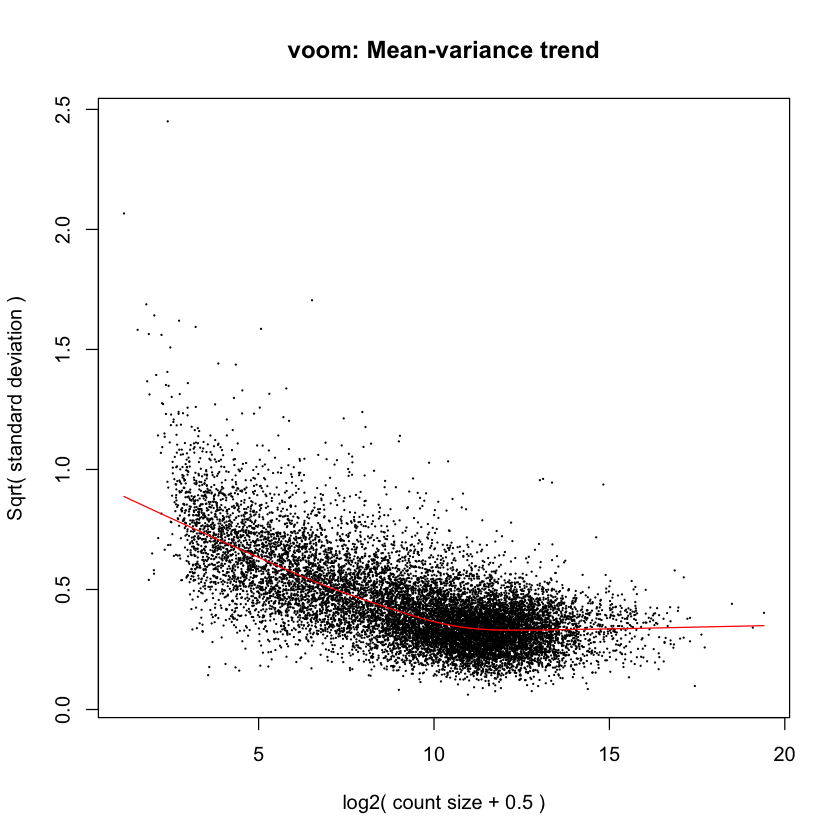

In [11]:
#normalise counts and run voom
dge<-DGEList(counts=Mcounts)
dge<-calcNormFactors(dge)

y<-voom(dge,design,plot=TRUE)

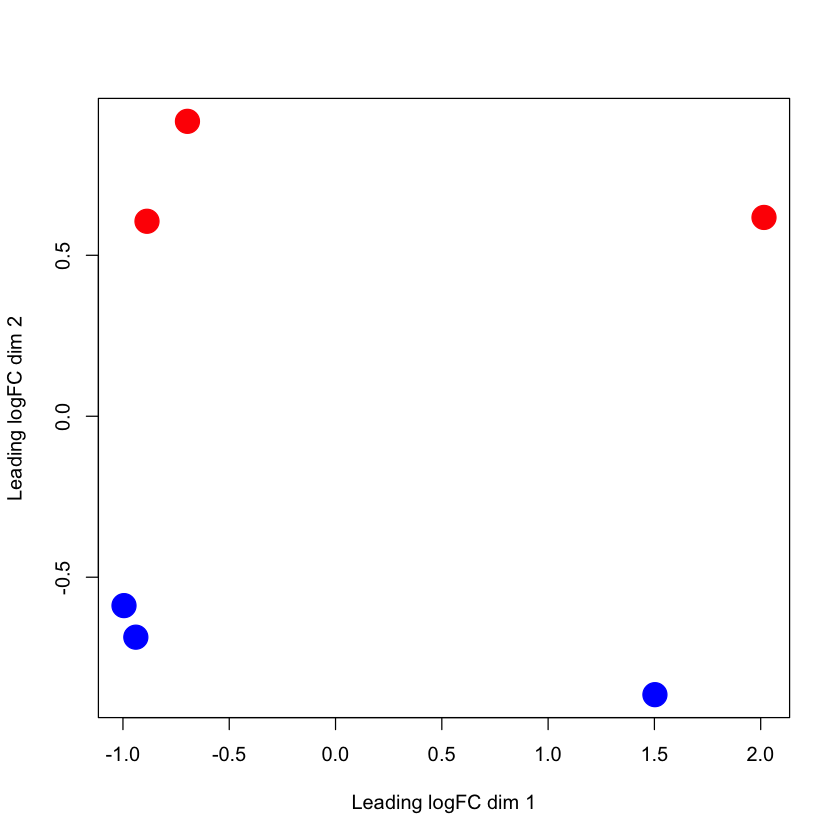

In [12]:
# MDS plot
# dimension 1 is sex and 2 is overexpression versus control
plotMDS(y,col=c(rep("red",3),rep("blue",3)),cex=4,pch=20)
fit <- eBayes(lmFit(y,design))
voom_res=topTable(fit,n=dim(Mcounts)[1],sort.by="p",coef=2)

In [13]:
#clean up the results table
info=gene_info[rownames(voom_res),]

res=data.frame( info$Symbol, info$Position, voom_res$logFC, voom_res$adj.P.Val,
               voom_res$adj.P.Val<0.05,
               apply(Mcounts[rownames(voom_res),],2,function(x){x/sum(x)})*10^6)

colnames(res)<-c("Symbol","PositionGalGal4",
                 "Log2FoldChange","AdjustedPValue","DE",
                 paste("CPM",colnames(Mcounts),sep="-"))

rownames(res)<-rownames(voom_res)

options(digits=3)
res[res$DE,]
#our true positive, NKX2-5, comes up on top as expected.

,Symbol,PositionGalGal4,Log2FoldChange,AdjustedPValue,DE,CPM-11,CPM-18,CPM-9,CPM-3,CPM-4,CPM-5
ENSGALG00000002886,NKX2-5,chr13:8535720-8537935,15.033,0.000279,TRUE,748.544,507.818,577.683,0.0000,0.0000,0.0404
ENSGALG00000002242,GALNT9,chr15:2342101-2458959,1.492,0.008334,TRUE,19.534,20.606,32.941,8.2455,6.8511,11.0017
ENSGALG00000026903,CALB2,chr11:1479309-1484634,7.952,0.012265,TRUE,10.515,5.134,21.472,0.0257,0.0362,0.0404
ENSGALG00000002893,STC2,chr13:8561503-8571173,1.643,0.012265,TRUE,16.847,15.772,11.012,5.9850,4.1505,4.0575
ENSGALG00000011893,SLC38A6,chr5:54134020-54169085,0.818,0.012265,TRUE,176.136,176.481,155.504,97.8928,94.7918,95.8057
ENSGALG00000009693,CPXM2,chr6:31278696-31344582,1.057,0.012265,TRUE,35.774,37.489,48.907,18.3148,19.0852,21.1354
ENSGALG00000009393,CAV1,chr1:24999076-25013429,2.353,0.012265,TRUE,5.514,6.198,4.839,0.8477,1.2143,1.1305
ENSGALG00000013892,MAP3K5,chr3:54290127-54341428,1.336,0.012265,TRUE,52.645,38.529,55.309,21.1403,18.1609,18.7130
ENSGALG00000013085,PTPRO,chr1:62933510-63081609,1.403,0.016656,TRUE,13.786,15.056,22.463,6.6529,5.7999,6.9846
ENSGALG00000009280,NPY2R,chr4:20013682-20014840,-1.140,0.016656,TRUE,12.618,14.616,10.269,27.7419,27.8757,26.2628


In [14]:
sessionInfo()

R version 3.4.0 (2017-04-21)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Sierra 10.12.3

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRlapack.dylib

locale:
[1] en_AU.UTF-8/en_AU.UTF-8/en_AU.UTF-8/C/en_AU.UTF-8/en_AU.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] edgeR_3.18.1 limma_3.32.2

loaded via a namespace (and not attached):
 [1] locfit_1.5-9.1      lattice_0.20-35     digest_0.6.12      
 [4] crayon_1.3.2        IRdisplay_0.4.4     grid_3.4.0         
 [7] repr_0.12.0         R6_2.2.0            jsonlite_1.4       
[10] magrittr_1.5        evaluate_0.10       stringi_1.1.5      
[13] uuid_0.1-2          IRkernel_0.8.6.9000 tools_3.4.0        
[16] stringr_1.2.0       compiler_3.4.0      pbdZMQ_0.2-5       